# Imports

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

%reload_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append('../fastai/') #fastai version 1.0
from fastai.vision import *
from fastai.vision.learner import model_meta

sys.path.append('../models-pytorch/pretrained-models.pytorch')
import pretrainedmodels
from pretrainedmodels import *

import pandas as pd
import numpy as np
import os
import torch
import torchvision
from torchvision.models import *
from torchsummary import summary
from pathlib import Path
from functools import partial, update_wrapper
from tqdm import tqdm_notebook as tqdm
import PIL
import imageio
import shutil

PATH = Path('/home/Deep_Learner/work/network/datasets/2018_dsb')
TRAIN_NAME = 'stage1_train_fixed'
TRAIN = PATH/TRAIN_NAME
MASKS_NAME = 'stage1_masks'
MASKS = PATH/MASKS_NAME
CSV_NAME = 'stage1_train_labels.csv'
TRAIN_PATHS_CSV_NAME = 'stage1_train_paths_fixed.csv'
TRAIN_PATHS_CSV = PATH/TRAIN_PATHS_CSV_NAME
LABELS = PATH/CSV_NAME
TEST_NAME = 'stage2_test_final'
TEST = PATH/TEST_NAME
TEST_ONE_FOLDER_NAME = 'stage2_test_final_one_folder'
TEST_ONE_FOLDER = PATH/TEST_ONE_FOLDER_NAME
SAMPLE = PATH/'stage2_sample_submission_final.csv'
TEST_PATHS_CSV_NAME = 'stage2_test_paths.csv'
TEST_PATHS_CSV = PATH/TEST_PATHS_CSV_NAME
SUBMISSIONS = PATH/'submissions'
SUBMISSIONS.mkdir(exist_ok=True)

nw = 8   #number of workers for data loader
torch.backends.cudnn.benchmark=True
seed = 42
np.random.seed(seed)

def batch_stats(self, funcs:Collection[Callable]=None)->Tensor:
        "Grab a batch of data and call reduction function `func` per channel"
        funcs = ifnone(funcs, [torch.mean,torch.std])
        x = self.one_batch(ds_type=DatasetType.Train, denorm=False)[0].cpu()
        return [func(channel_view(x), 1) for func in funcs]

    
vision.data.ImageDataBunch.batch_stats = batch_stats

def split_path(path:Union[str, Path])-> list:
    return os.path.normpath(path).split(os.sep)
    

sz = 128
bs = 2
epochs_freezed = 1
epochs_unfreezed = 20

#fastai defaults
tta_beta = 0.4 
tta_scale = 1.35
dropout = 0.5
wd = 0.01

#non defaults
#wd = 0.1 not better for se_resnext50

# n

In [2]:
n=1

In [45]:
n = np.load('n.npy')
n

array(1)

In [46]:
m = n+1
#m=1
np.save('n', m)
m

2

# Data

## Data preparation 

### train paths csv 

In [ ]:
df = pd.read_csv(LABELS)
df.head()

ids = list(set(df.ImageId))

paths = []

for n, i in tqdm(enumerate(ids), total=len(ids)):
    p = Path(f'{TRAIN_NAME}/{i}/images/{i}.png')
    try:
        open_image(PATH/p)
        paths.append(p)
    except:
        continue

len(paths)

df_paths = pd.DataFrame(data=paths, columns=['paths'])

df_paths.to_csv(index=False, path_or_buf=TRAIN_PATHS_CSV)

###  move test images into one folder

In [9]:
df = pd.read_csv(SAMPLE)
df.head()

ids = list(set(df.ImageId))

paths = []

for n, i in tqdm(enumerate(ids), total=len(ids)):
    p = Path(f'{TEST_NAME}/{i}/images/{i}.png')
    try:
        open_image(PATH/p)
        paths.append(p)
    except:
        continue

len(paths)

df_paths = pd.DataFrame(data=paths, columns=['paths'])

df_paths.to_csv(index=False, path_or_buf=TEST_PATHS_CSV)

TEST_ONE_FOLDER.mkdir(exist_ok=True)

for p in pd.read_csv(TEST_PATHS_CSV).paths:
    dest = PATH/TEST_ONE_FOLDER_NAME/os.path.split(p)[-1]
    shutil.move(PATH/p, dest)

,ImageId,EncodedPixels
0,0019c086029dd3be01f72131edb74e21ee995574e6d5c1...,1 1
1,004a078bb44ee55ee7d6f1c19f96b3a0d3b5037746a3a7...,1 1
2,005463e6d4a0a0b21161f1d97392f22556fbddba970d94...,1 1
3,005af293e8e53218ae96746ecf9bb88b511154d4a0b35e...,1 1
4,005d47447abac7f7fa0ac56ba82f13edbf485105baf067...,1 1


### Combine single nucleus masks to one mask per image

In [20]:
def get_mask(path:Union[str,Path], size:int)->np.array:
    """
    path: path to folder with masks of single nuclei
    size: size for resizing imgs
    """
    shape = open_mask(list(path.iterdir())[0]).shape   
    mask = np.zeros(shape=(shape[1], shape[2], 1),dtype=np.uint8)
    for m in list(path.iterdir()):
        #nucleus = np.array(PIL.Image.open(m).resize((size,size)), dtype=np.uint8)
        nucleus = np.array(PIL.Image.open(m), dtype=np.uint8)
        nucleus = np.expand_dims(nucleus, axis=-1)
        mask = np.maximum(mask, nucleus)
    mask = mask/255
    mask = mask.astype(np.uint8)
    return np.squeeze(mask)

    
def show_mask(mask:np.array):
    plt.imshow(np.squeeze(mask))

    
def save_mask(mask:np.array, path:Path, filename:str, suffix:str):
    path.mkdir(exist_ok=True)
    imageio.imwrite(f'{path}/{filename}{suffix}', mask)
    

ids = [os.path.splitext(os.path.split(p)[-1])[0] for p in pd.read_csv(TRAIN_PATHS_CSV).paths]

for i in tqdm(ids[:]):
    p = PATH/TRAIN_NAME/i/'masks'
    mask = get_mask(p, sz)
    save_mask(mask, MASKS, i, '.png')

In [21]:
pd.read_csv(TRAIN_PATHS_CSV).paths[0]

'stage1_train_fixed/4e07a653352b30bb95b60ebc6c57afbc7215716224af731c51ff8d430788cd40/images/4e07a653352b30bb95b60ebc6c57afbc7215716224af731c51ff8d430788cd40.png'

In [22]:
pa = PATH/'stage1_train_fixed/4e07a653352b30bb95b60ebc6c57afbc7215716224af731c51ff8d430788cd40/masks'

In [23]:
import numpy
numpy.set_printoptions(threshold=numpy.nan)

get_mask(pa, sz)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

## Databunch

In [25]:
def get_y_fn(x): return PATH/MASKS/os.path.split(x)[-1]

tfms = ([crop(size=sz),
        RandTransform(tfm=TfmAffine (dihedral_affine), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True),
        RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.475, 0.525)}, p=0.75, resolved={}, do_run=True, is_random=True),
        RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.95, 1.0526315789473684)}, p=0.75, resolved={}, do_run=True, is_random=True)],
      #RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True),
      #RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.75, resolved={}, do_run=True, is_random=True),
      #RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True),
      #RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do_run=True, is_random=True)],
     [crop(size=sz)])

In [26]:
data = (SegmentationItemList.from_csv(path=PATH, csv_name=TRAIN_PATHS_CSV_NAME)
        .split_by_rand_pct(valid_pct=0.2, seed = seed)
        .label_from_func(get_y_fn, classes=array(['background', 'nucleus']))
         #.add_test_folder(TEST_ONE_FOLDER)
        .transform(tfms, tfm_y=True, size=sz)
        .databunch(bs=bs)
        .normalize())

# Losses and Metrics

In [35]:
import keras.backend as K
from keras.losses import categorical_crossentropy


def hard_dice_coef(y_true, y_pred, smooth=1e-3):
    y_true_f = K.flatten(K.round(y_true[..., 0]))
    y_pred_f = K.flatten(K.round(y_pred[..., 0]))
    intersection = K.sum(y_true_f * y_pred_f)
    return 100. * (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def hard_dice_coef_ch1(y_true, y_pred, smooth=1e-3):
    y_true_f = K.flatten(K.round(y_true[..., 1]))
    y_pred_f = K.flatten(K.round(y_pred[..., 1]))
    intersection = K.sum(y_true_f * y_pred_f)
    return 100. * (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef(y_true, y_pred, smooth=1e-3):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return K.mean((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))


def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)


def dice_coef_loss_bce(y_true, y_pred, dice=0.5, bce=0.5):
    return binary_crossentropy(y_true, y_pred) * bce + dice_coef_loss(y_true, y_pred) * dice


def binary_crossentropy(y, p):
    return K.mean(K.binary_crossentropy(y, p))


def double_head_loss(y_true, y_pred):
    mask_loss = dice_coef_loss_bce(y_true[..., 0], y_pred[..., 0])
    contour_loss = dice_coef_loss_bce(y_true[..., 1], y_pred[..., 1])
    return mask_loss + contour_loss


def mask_contour_mask_loss(y_true, y_pred):
    mask_loss = dice_coef_loss_bce(y_true[..., 0], y_pred[..., 0])
    contour_loss = dice_coef_loss_bce(y_true[..., 1], y_pred[..., 1])
    full_mask = dice_coef_loss_bce(y_true[..., 2], y_pred[..., 2])
    return mask_loss + 2 * contour_loss + full_mask


def softmax_dice_loss(y_true, y_pred):
    return categorical_crossentropy(y_true, y_pred) * 0.6 + dice_coef_loss(y_true[..., 0], y_pred[..., 0]) * 0.2 + dice_coef_loss(y_true[..., 1], y_pred[..., 1]) * 0.2


def make_loss(loss_name):
    if loss_name == 'bce_dice':
        def loss(y, p):
            return dice_coef_loss_bce(y, p, dice=0.5, bce=0.5)

        return loss
    elif loss_name == 'bce':
        def loss(y, p):
            return dice_coef_loss_bce(y, p, dice=0, bce=1)

        return loss
    elif loss_name == 'categorical_dice':
        return softmax_dice_loss
    elif loss_name == 'double_head_loss':
        return double_head_loss
    elif loss_name == 'mask_contour_mask_loss':
        return mask_contour_mask_loss
    else:
        ValueError("Unknown loss.")





from multiprocessing.pool import Pool

import numpy as np
from skimage import measure


def calculate_cell_score_kaggle(y_true, y_pred, num_threads=32):
    yps = []
    for m in range(len(y_true)):
        yps.append((y_true[m].copy(), y_pred[m].copy()))
    pool = Pool(num_threads)
    results = pool.map(score_kaggle, yps)
    return np.mean(results)


def calculate_cell_score_selim(y_true, y_pred, num_threads=32, ids=None):
    yps = []
    for m in range(len(y_true)):
        yps.append((y_true[m].copy(), y_pred[m].copy()))
    pool = Pool(num_threads)
    results = pool.map(calculate_jaccard, yps)
    if ids:
        import pandas as pd
        s_iou = np.argsort(results)
        d = []
        for i in range(len(s_iou)):
            id = ids[s_iou[i]]
            res = results[s_iou[i]]
            d.append([id, res])
            pd.DataFrame(d, columns=["ID", "METRIC_SCORE"]).to_csv("gt_vs_oof.csv", index=False)

    return np.array(results).mean()


def get_cells(mask):
    return measure.label(mask, return_num=True)

def score_kaggle(yp):
    y, p = yp
    return calc_score(np.expand_dims(y, 0), np.expand_dims(p, 0))



def calc_score(labels, y_pred):
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))
    #    print("Number of true objects:", true_objects)
    #    print("Number of predicted objects:", pred_objects)
    # Compute intersection between all objects
    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins=true_objects)[0]
    area_pred = np.histogram(y_pred, bins=pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:, 1:]
    union = union[1:, 1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1  # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    #    print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        p = tp / (tp + fp + fn)
        #        print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    #    print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)


def calculate_jaccard(yps):
    y, p = yps
    jaccards = []
    iou_thresholds = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
    for iou_threshold in iou_thresholds:
        tp = 0
        fp = 0
        fn = 0
        processed_gt = set()
        matched = set()
        size = p.shape[0], p.shape[1]
        mask_img = np.reshape(p, size)

        gt_mask_img = np.reshape(y, size)
        predicted_labels, predicted_count = get_cells(mask_img)
        gt_labels, gt_count = get_cells(gt_mask_img)

        gt_cells = [rp.coords for rp in measure.regionprops(gt_labels)]
        pred_cells = [rp.coords for rp in measure.regionprops(predicted_labels)]
        gt_cells = [to_point_set(b) for b in gt_cells]
        pred_cells = [to_point_set(b) for b in pred_cells]
        for j in range(predicted_count):
            match_found = False
            for i in range(gt_count):
                pred_ind = j + 1
                gt_ind = i + 1
                if match_found:
                    break
                if gt_ind in processed_gt:
                    continue
                pred_cell = pred_cells[j]
                gt_cell = gt_cells[i]
                intersection = len(pred_cell.intersection(gt_cell))
                union = len(pred_cell) + len(gt_cell) - intersection
                iou = intersection / union
                if iou > iou_threshold:
                    processed_gt.add(gt_ind)
                    matched.add(pred_ind)
                    match_found = True
                    tp += 1
            if not match_found:
                fp += 1
        fn += gt_count - len(processed_gt)
        jaccards.append(tp / (tp + fp + fn))
    return np.mean(jaccards)


def to_point_set(cell):
    return set([(row[0], row[1]) for row in cell])

Using TensorFlow backend.


# Learner

## Create

In [33]:
arch = torchvision.models.resnet34

In [36]:
learner = unet_learner(data = data, 
                       arch = torchvision.models.resnet50, 
                       #metrics=[calculate_cell_score_kaggle, calculate_cell_score_selim, calculate_jaccard], 
                       wd=wd, 
                       bottle=True)

## Name 

In [37]:
nameBase = f'{n}-{arch.__name__}-sz{sz}-bs{bs}'
nameBase

'1-resnet34-sz128-bs2'

## Train 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


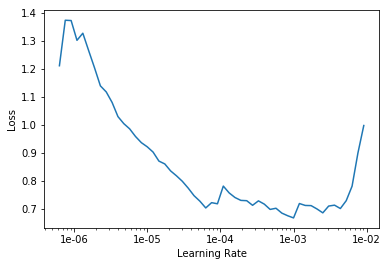

In [38]:
learner.lr_find()
learner.recorder.plot()

In [39]:
lr = 1e-4

In [40]:
learner.fit_one_cycle(cyc_len=3, max_lr=slice(lr))

epoch,train_loss,valid_loss,time
0,0.156769,0.709732,01:02
1,0.079855,0.133463,01:03
2,0.073037,0.114087,01:03


In [ ]:
nameHead = f'{nameBase}-head'

In [ ]:
learner.save(nameHead)

In [ ]:
learner.unfreeze()

In [ ]:
learner.lr_find()
learner.recorder.plot()

In [ ]:
lr2 = 
lr3 = 

In [ ]:
learner.fit_one_cycle(cyc_len=, max_lr=slice(lr2, lr3))

In [ ]:
learner.recorder.plot_losses()

In [ ]:
nameComplete = f'{nameBase}-complete'
learner.save(nameComplete)

### Best learning schedules

# Look at results 

# Predictions 